# Analysis of Parameter Estimation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tellurium as te  
import json
import os
import re
import sys
sys.path.append('../Estimation/')
from estimation import set_model_to_ss

In [2]:
def simulate_model2(model="no", model_path = '../LCT_model/general_LCT_OIE.ant', 
                   infection_pars: dict = {}, name='general', 
                   ss_duration:float=4., pre_t:float=10.0, simulation_end:float=50.0, 
                   bool_med=True, bool_set_pars=False, bool_infct=True,
                   selections:list=['time', '[R]', '[iE]', '[E]','[M]','[P]', 'oiE', 'Hkt',
                                     'Hb', 'LDH', 'parasitemia', 'RPI', 'J_oiE_death',
                                     'J_P_birth', 'J_P_death',
                                     'k_E_death','rpi_step_func'] 
                                     + [f'[oiE_{i}]' for i in range(1, 7)]):
    """Simulates model for given BH_max value and returns dataframe with results. 
    Includes presimulation for specific time (infection_after)."""
    if type(model)==str:
        model = te.loada(model_path)
   
    if bool_set_pars:
        for p in infection_pars:
            try:
                model.setValue(p, infection_pars[p])    # CAUTION: if you include a volume which is not 1 in the model, species might get fucked up
            except RuntimeError:
                continue
            
    model = set_model_to_ss(model,infection_pars, model_name=name)
    
    # ss simulation
    model.M = 0
    model.events_medication_on = False 
    ss_res = model.simulate(-ss_duration-pre_t, -pre_t, 10, selections=selections)
    ss_res_df = pd.DataFrame(ss_res, columns=ss_res.colnames)    

    # infection simulation
    for p in infection_pars:
         try:
             model.setValue(p, infection_pars[p])    # CAUTION: if you include a volume which is not 1 in the model, species might get fucked up
         except RuntimeError:
             continue
    # no infection bool
    if not bool_infct:
        model.M = 0

    # ACT addition
    model.events_medication_on = bool_med
    act_res = model.simulate(-pre_t, simulation_end, 501, selections=selections) #int(simulation_end+pre_t)*10
    act_res_df = pd.DataFrame(act_res, columns=act_res.colnames) 

    # combine results
    res_df = pd.concat([ss_res_df, act_res_df], axis=0)    
    return res_df 

def akaike_score(model, esti_score):
    # remove all fluxes J from parameter space of model.ps()
    pattern =  re.compile("^(?!.*J).*")
    filtered_strings = [str(s) for s in model.ps() if re.match(pattern, str(s))]
    
    aka_score = 2*len(filtered_strings) - 2 * np.log(esti_score**(-1))
    return aka_score, len(filtered_strings), filtered_strings

In [3]:
akaike_score_dict = {}

### Load all data relevant for analysis

In [24]:
name = 'general'
pth_model = te.loada(f'../LCT_model/{name}_LCT_OIE.ant')
non_pth_model = te.loada(f'../LCT_model/{name}_LCT_OIE.ant')

data = pd.read_csv('../datasets/OIE_data.csv')

# Define the directory containing the files
directory = f'../Estimation/{name}/pth/'

# Initialize an empty list to store file names
file_list = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    # Check if the path is a file (not a directory)
    if os.path.isfile(filepath):
        # Add the file path to the list
        file_list.append(filepath)
file_list = sorted(file_list)
newest_file_name = file_list[-1].split("/")[-1].split(".")[0]
estimation_run = newest_file_name                          
#estimation_run = '2024_02_13_16_28_1' # all separate

#estimation_run = "2024_02_07_15_51_1" # hill function estimation
#no hill function estimation, too high J_P_death but better R: "2023_12_20_17_13_1" 
#estimation Hkt_init: "2023_12_18_11_09_1"
#nice curves, estimated k_P_birth: 2023_12_14_14_50_1           
#Best cost function, but new steady state as k_P_birth higher: "2023_12_15_10_44_1"

fit_data_pth = pd.read_csv('../Estimation/pth.csv')
with open(f'../Estimation/{name}/pth/{estimation_run}.json', 'r') as f:
  pth_result = json.load(f)

fit_data_non_pth = pd.read_csv('../Estimation/non_pth.csv')
with open(f'../Estimation/{name}/non_pth/{estimation_run}.json', 'r') as f:
  non_pth_result = json.load(f)
print(estimation_run)

2024_08_20_15_22_20


In [25]:
species_selct = ['time', '[R]', '[iE]', '[E]', 'oiE', 'Hkt', 'Hb', 'LDH',
                 'parasitemia', 'RPI', 'J_P_aging', 'J_P_death', '[P]',"J_P_birth",
                 'J_oiE_death', 'k_E_death', 'k_P_birth'] + [f'[oiE_{i}]' for i in range(1, 7)]
pth_model.resetToOrigin()
for p in pth_result['update_parameters']:
    pth_model.setValue(p, pth_result['update_parameters'][p])
    
pre_t = pth_result['best_parameters']['pre_t']
pth_res = pth_model.simulate(-pre_t, 50, 200, selections=species_selct)
g_pth_res_df = pd.DataFrame(pth_res, columns=pth_res.colnames) 

akaike_score_dict[f'{name}_pth'] = akaike_score(pth_model, pth_result['best_score'])

non_pth_model.resetToOrigin()
for p in non_pth_result['update_parameters']:
    non_pth_model.setValue(p, non_pth_result['update_parameters'][p])

pre_t = non_pth_result['best_parameters']['pre_t']
#non_pth_model.events_medication_on = False
non_pth_res = non_pth_model.simulate(-pre_t, 50, 200, selections=species_selct)
g_non_pth_res_df = pd.DataFrame(non_pth_res, columns=non_pth_res.colnames) 

akaike_score_dict[f'{name}_non'] = akaike_score(non_pth_model, non_pth_result['best_score'])


In [ ]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[P]', 'J_P_aging', 'J_P_death',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(g_pth_res_df['time'], g_pth_res_df[obs], label='no BH')
    ax[row, col].plot(g_pth_res_df['time'], g_pth_res_df[obs])

    ax[row, col].set_title(obs+"_pth")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='data')
# maturation time = 1, assumption Hkt does go underneath 0.4, in model   
rpi_calc = (g_pth_res_df['[R]'] / (g_pth_res_df['[R]'] + g_pth_res_df['[E]']+g_pth_res_df['[iE]'] + g_pth_res_df['oiE'])) * g_pth_res_df['Hkt'] / (0.45*0.01)
ax[3, 1].plot(g_pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()

<Figure size 900x1000 with 15 Axes>

In [ ]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death','[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(pth_res_df['time'], pth_res_df[obs], label='no BH')
    ax[row, col].plot(g_non_pth_res_df['time'], g_non_pth_res_df[obs])

    ax[row, col].set_title(obs+"_non_pth")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='data')

plt.tight_layout()  
plt.show()


<Figure size 900x800 with 12 Axes>

In [ ]:
def pretty_plot(results, axs=None, c=None, bool_med=True):
    species_to_analyze = {
        'parasitemia' : ['parasitemia (%)', 1],
        #'[M]' : ['M (1e4/µl)', 1e4],
        '[iE]': ['iE (1e4/µl)', 1e4],
        'oiE': ['oiE (1e4/µl)', 1e4],
        '[E]': ['E (1e4/µl)', 1e4],
        '[R]': ['R (1e4/µl)', 1e4],
        #'[P]': ['P (1e0/µl)', 1e0],
        #'J_P_birth':['J_P_birth',1e0],
        'Hb': ['Hb (g/dl)', 1],
        'Hkt': ['Hct', 1],
        'RPI': ['RPI', 1],
        'LDH': ['LDH (U/l)',1],
    }
    if axs.dtype==None:
        # Durchführung des Parameter-Scans und Erstellung der Plots
        cols = 3
        rows = int(np.ceil(len(species_to_analyze)/cols))   

        fig, axs = plt.subplots(rows,cols, figsize=(20,15), sharex=True)
        fig.subplots_adjust(hspace=0.38, wspace= 0.42)
    size_of_font = 24

    # Farbübergang
    if c ==None:
        cmap = plt.colormaps.get_cmap('Reds')
        c=cmap(0.8)

    for j, specie in enumerate (species_to_analyze.keys()):

        row = j //3
        col = j % 3


        axs[row, col].plot(results['time'], results[specie]/species_to_analyze[specie][1],
                            color=c, label='m')
        #axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
        axs[row, col].set_ylabel(species_to_analyze[specie][0],fontsize= size_of_font)
        axs[row, col].tick_params(labelsize=size_of_font)
        if bool_med:
            axs[row, col].axvspan(0, 0.3, facecolor='mediumseagreen', alpha=1, label='ACT Administration')
            axs[row, col].axvspan(1, 1.3, facecolor='mediumseagreen', alpha=1,)
            axs[row, col].axvspan(2, 2.3, facecolor='mediumseagreen', alpha=1,)

        axs[row, col].axvline(-10, color='navy', alpha=1, linewidth=2, linestyle=(0, (3, 5, 1, 5)), label='Infection')   
        axs[row, col].tick_params(bottom='on')   
        if row == 3 - 1:
                axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
        
        
    #handles, labels = axs[row, col].get_legend_handles_labels()  # Legend Box outsides Subplots


    #axs[-1, -1].legend(handles, labels, loc='lower left', 
                        #bbox_to_anchor=(1.05, 0.7),fontsize= size_of_font) #bbox (nach rechts-links, oben-unten, negativ yes)


    #plt.savefig("./figures/paramscan_BHmax_short.pdf", format="pdf",bbox_inches='tight')
    #plt.show()
    return axs

In [ ]:
cols = 3
rows = 3  
fig, axs_all = plt.subplots(rows,cols, figsize=(15,10), sharex=True)
fig.subplots_adjust(hspace=0.38, wspace= 0.42)
size_of_font = 24
color = ['tab:orange','tab:blue']
for i,data in enumerate([g_pth_res_df,g_non_pth_res_df]):
    pretty_plot(data, axs_all, color[i])
axs_all[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data', color='tab:blue')
axs_all[1,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data',color='tab:blue')
axs_all[1,1].plot(fit_data_non_pth['Time'], fit_data_non_pth['[R]_mean']/1e4, 'o', label='data', color='tab:blue')

axs_all[2,2].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='PTH data',color='tab:orange')
axs_all[1,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='PTH data',color='tab:orange')
axs_all[1,1].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean']/1e4, 'o', label='PTH data',color='tab:orange')

handles, labels = axs_all[1, -1].get_legend_handles_labels()  # Legend Box outsides Subplots

axs_all[1,-1].legend(handles[0:1]+handles[3:4]+handles[6:]+handles[1:3], ['PTH model','non PTH model','data non','data PTH','ACT administration','Infection start'], loc='center left', 
                  bbox_to_anchor=(1.02, 0.5), fontsize=15
                  ) 
plt.tight_layout()  

#fig.savefig('general_model.svg', dpi=300)


<Figure size 1500x1000 with 9 Axes>

In [ ]:
def load_file(file_loc: str):
    '''
    Function to load file either json or pickled .txt
    ---------------------------------------------------
    Parameter:
    file_loc: str path to file
    ---------------------------------------------------
    returns:
    data: either unpickled tuple or list 
    '''
    if file_loc.endswith('.txt'):
            with open(file_loc, 'rb') as g:
                # data = tuple with [0]=score, [1]=parameter_dict
                data = pickle.loads(g.read())
    else:
        with open(file_loc, 'r') as g:
            # data = list with [0]=score, [1]=parameter_dict
            data = json.loads(g.read())

    return data

def get_best_parameter_set(d_path, best:bool = False):
    '''
    Description: function to find the best scoring parameter set for specified model
    -----------
    Parameter:
    d_path: pathway to directory with parameter sets
    n_sets: number of best sets 
    best:   bool if only best parameter set is returned as dict 
    ----------
    returns:
    dresults: pd.DataFrame() with best score as name and parameter names as index
    '''
    d_path = d_path
    files = os.listdir(d_path)
    files = [file for file in files if '.json' in file]
    
    results = {}
    for file in files:
        filename = file
        path = d_path
        
        data = load_file(path+filename)
        #print(data["update_parameters"])
        results[str(data["best_score"])]= filename
        
    # sort the colums names to find lowest estimation score   
    results_str = sorted(list(map(float, results.keys())))
    results_str = np.asarray(results,dtype=str)
    if best:
        print(f'Best score={results_str[0]}',results[results_str[0]])
        

def load_models(location:str, file_num:int =-1):
    pth_model = te.loada(f'../LCT_model/{location}_LCT_OIE.ant')
    non_pth_model = te.loada(f'../LCT_model/{location}_LCT_OIE.ant')

    # Define the directory containing the files
    directory = f'../Estimation/{location}/pth/'
    #get_best_parameter_set(directory)
    # Initialize an empty list to store file locations
    file_list = []

    # Iterate over files in the directory
    for filelocation in os.listdir(directory):
        filepath = os.path.join(directory, filelocation)
        # Check if the path is a file (not a directory)
        if os.path.isfile(filepath):
            # Add the file path to the list
            file_list.append(filepath)
    file_list = sorted(file_list)
    newest_file_location = file_list[file_num].split("/")[-1].split(".")[0]
    estimation_run = newest_file_location                          
    # Load estimation relevant data sets
    fit_data_pth = pd.read_csv('../Estimation/pth.csv')
    with open(f'../Estimation/{location}/pth/{estimation_run}.json', 'r') as f:
        pth_result = json.load(f)

    fit_data_non_pth = pd.read_csv('../Estimation/non_pth.csv')
    with open(f'../Estimation/{location}/non_pth/{estimation_run}.json', 'r') as f:
        non_pth_result = json.load(f)
    print(estimation_run)
    return pth_model, non_pth_model, fit_data_pth, pth_result, fit_data_non_pth, non_pth_result

## Immune model - innocent bystander

In [ ]:
name = 'immune'
num=-3
# beware set_model_to_ss has been reworked older parameter sets are not in perfect staedy state
pth_model, non_pth_model, fit_data_pth, pth_result, fit_data_non_pth, non_pth_result = load_models(name,file_num=num)


2024_08_21_10_56_25


In [ ]:
name = 'immune'
species_selct = ['time', '[R]', '[iE]', '[E]', 'oiE', 'Hkt', 'Hb', 'LDH','[Ttox]','[Treg]',
                 'parasitemia', 'RPI', 'J_P_aging', 'J_P_death', '[P]',"J_P_birth",
                 'J_oiE_death', 'k_E_death', 'k_P_birth'] + [f'[oiE_{i}]' for i in range(1, 7)]
pth_model.resetToOrigin()
for p in pth_result['update_parameters']:
    try:
        pth_model.setValue(p, pth_result['update_parameters'][p])
    except RuntimeError:
        continue

pre_t = pth_result['best_parameters']['pre_t']
#pth_res = pth_model.simulate(-pre_t, 100, 200, selections=species_selct)
# beware set_model_to_ss has been reworked older parameter sets are not in perfect steady state
i_pth_res_df = simulate_model2(pth_model, infection_pars=pth_result['update_parameters'], 
                             name='immune', ss_duration=10, simulation_end=50,
                             selections=species_selct)

akaike_score_dict[f'{name}_pth'] = akaike_score(pth_model, pth_result['best_score'])
non_pth_model.resetToOrigin()
for p in non_pth_result['update_parameters']:
    try:
        non_pth_model.setValue(p, non_pth_result['update_parameters'][p])
    except RuntimeError:
        continue
pre_t = non_pth_result['best_parameters']['pre_t']
#non_pth_model.events_medication_on = False
# beware set_model_to_ss has been reworked older parameter sets are not in perfect steady state
i_non_pth_res_df = simulate_model2(non_pth_model, infection_pars=non_pth_result['update_parameters'], 
                                 name='immune', ss_duration=10, simulation_end=50,
                                 selections=species_selct)

akaike_score_dict[f'{name}_non'] = akaike_score(non_pth_model, non_pth_result['best_score'])

/home/nexia/miniconda3/envs/phd/lib/python3.10/site-packages/roadrunner/roadrunner.py:4687: UserWarning:

Simulation requested end time point (-10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. rr.simulate(-20.0, -10.0, 1001)
  * Setting rr.integrator.variable_step_size to 'False'
  * Setting rr.integrator.max_output_rows to a larger number 

/home/nexia/miniconda3/envs/phd/lib/python3.10/site-packages/roadrunner/roadrunner.py:4687: UserWarning:

Simulation requested end time point (-10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. rr.simulate(-20.0, -10.0, 1001)
  * Setting rr.integrator.variable_step_size to 'False'
  * Setting rr.integrator.max_output_rows to a larger number 



In [ ]:
from sympy import solveset, S, symbols

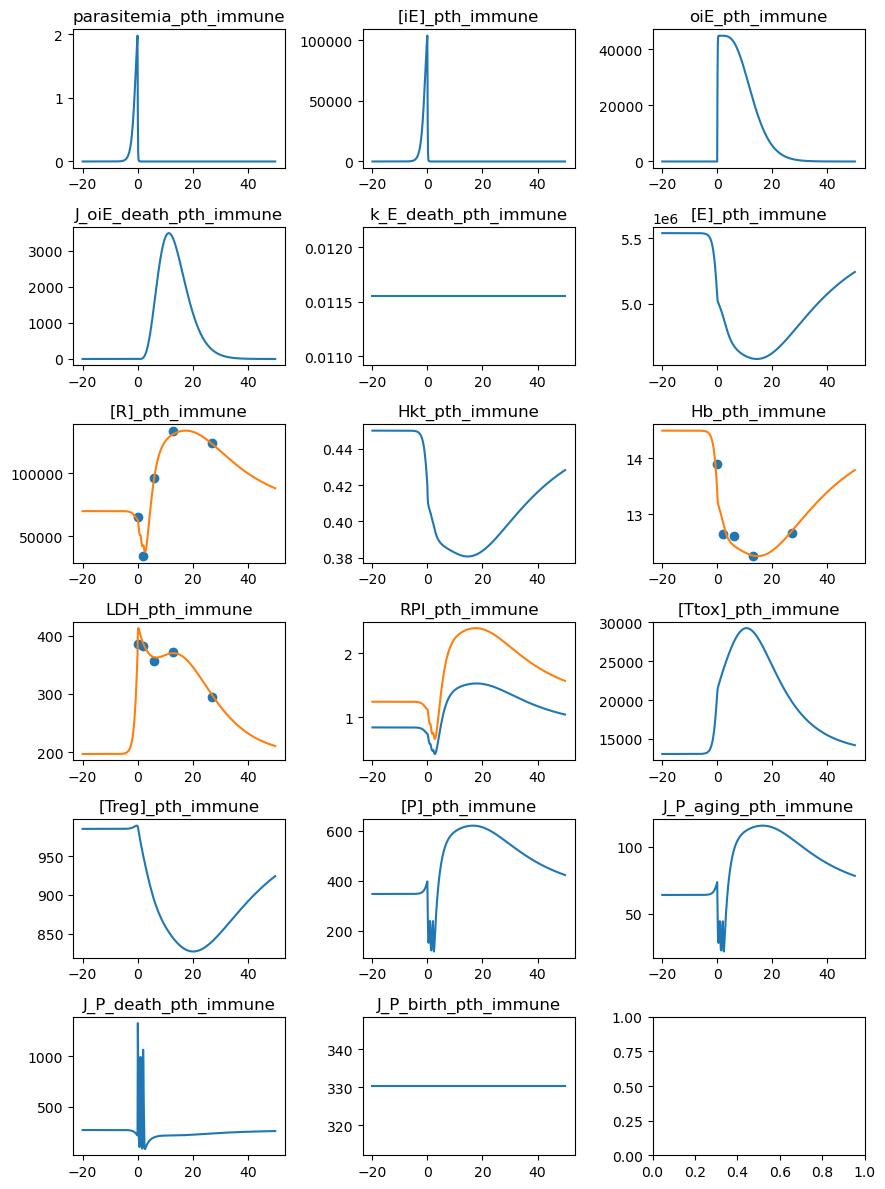

In [ ]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[Ttox]','[Treg]','[P]',
               'J_P_aging', 'J_P_death',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))
ax[3,0].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='data')
for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(i_pth_res_df['time'], i_pth_res_df[obs], label='no BH')
    ax[row, col].plot(i_pth_res_df['time'], i_pth_res_df[obs])

    ax[row, col].set_title(obs+f"_pth_{name}")
    #ax[row, col].legend()

# maturation time = 1, assumption Hkt does go underneath 0.4, in model   
rpi_calc = (i_pth_res_df['[R]'] / (i_pth_res_df['[R]'] + i_pth_res_df['[E]']+i_pth_res_df['[iE]'] + i_pth_res_df['oiE'])) * i_pth_res_df['Hkt'] / (0.45*0.01)
ax[3, 1].plot(i_pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()

In [ ]:
i_pth_res_df

,time,[R],[iE],[E],oiE,Hkt,Hb,LDH,[Ttox],[Treg],...,J_P_birth,J_oiE_death,k_E_death,k_P_birth,[oiE_1],[oiE_2],[oiE_3],[oiE_4],[oiE_5],[oiE_6]
0,-20.000000,69812.755286,0.000000e+00,5.537734e+06,0.000000,0.450000,14.496792,197.094878,13051.719497,984.916493,...,330.316898,0.000000,0.011552,330.316898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-18.888889,69812.755286,0.000000e+00,5.537734e+06,0.000000,0.450000,14.496792,197.094878,13051.719497,984.916493,...,330.316898,0.000000,0.011552,330.316898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-17.777778,69812.755286,0.000000e+00,5.537734e+06,0.000000,0.450000,14.496792,197.094878,13051.719497,984.916493,...,330.316898,0.000000,0.011552,330.316898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-16.666667,69812.755286,0.000000e+00,5.537734e+06,0.000000,0.450000,14.496792,197.094878,13051.719497,984.916493,...,330.316898,0.000000,0.011552,330.316898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-15.555556,69812.755286,0.000000e+00,5.537734e+06,0.000000,0.450000,14.496792,197.094878,13051.719497,984.916493,...,330.316898,0.000000,0.011552,330.316898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,49.520000,88382.391326,-5.637504e-26,5.236131e+06,0.710042,0.427729,13.774366,211.476043,14223.183476,922.944056,...,330.316898,0.247145,0.011552,330.316898,0.000013,0.000288,0.003158,0.023105,0.126797,0.556682
497,49.640000,88268.851683,2.062943e-26,5.237795e+06,0.680986,0.427850,13.778317,211.302540,14212.707052,923.278012,...,330.316898,0.237180,0.011552,330.316898,0.000012,0.000273,0.003008,0.022066,0.121390,0.534236
498,49.760000,88155.991145,8.304849e-26,5.239450e+06,0.653103,0.427972,13.782250,211.130866,14202.329419,923.610439,...,330.316898,0.227610,0.011552,330.316898,0.000012,0.000260,0.002866,0.021074,0.116211,0.512681
499,49.880000,88043.806054,1.265995e-25,5.241097e+06,0.626345,0.428092,13.786163,210.961004,14192.049597,923.941340,...,330.316898,0.218420,0.011552,330.316898,0.000011,0.000247,0.002731,0.020125,0.111250,0.491981


In [ ]:
M = pth_model.mu_tox * i_pth_res_df['[E]'].values[0] / i_pth_res_df['[Treg]'].values[0] # pth_model.mu_tox * pth_model.delta_Treg / pth_model.beta_Treg # 

A = -pth_model.epsilon
B = pth_model.V_f - pth_model.delta_Ttox -  pth_model.K_f * pth_model.epsilon
C = M - pth_model.delta_Ttox * pth_model.K_f
D = M * pth_model.K_f

T = symbols('T')
p = solveset(A*T**3 +B*T**2 + C*T + D,T, domain=S.Reals)
print(i_pth_res_df['[Ttox]'].values[0],i_pth_res_df['[Ttox]'].values[-1])
p

13051.719497194672 14181.866613320191


{-67471.2688502103, -1.83515142106346, 13051.7194971947}

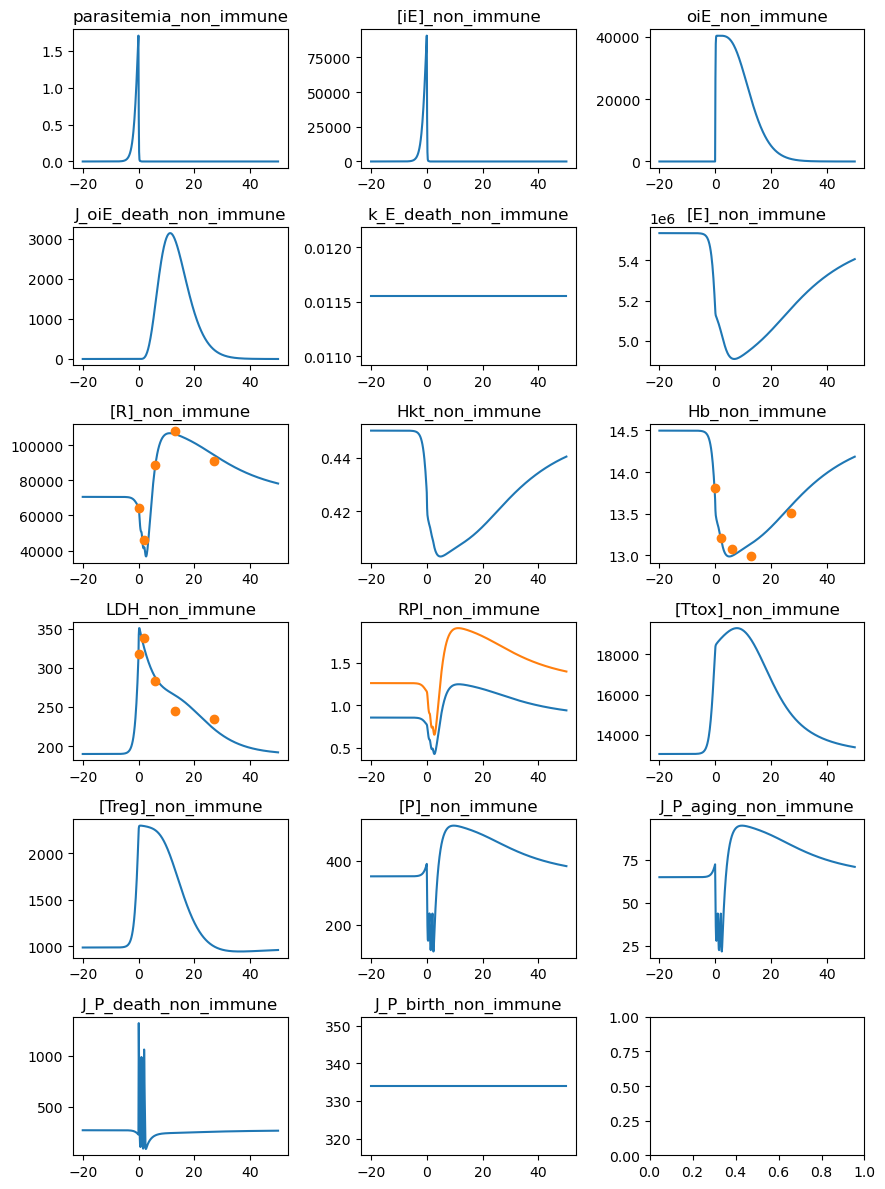

In [ ]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[Ttox]','[Treg]','[P]',
               'J_P_aging', 'J_P_death',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(i_non_pth_res_df['time'], i_non_pth_res_df[obs], label='no BH')
    ax[row, col].plot(i_non_pth_res_df['time'], i_non_pth_res_df[obs])

    ax[row, col].set_title(obs+f"_non_{name}")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['[R]_mean'], 'o', label='data')
# maturation time = 1, assumption Hkt does go underneath 0.4, in model   
rpi_calc = (i_non_pth_res_df['[R]'] / (i_non_pth_res_df['[R]'] + i_non_pth_res_df['[E]']+i_non_pth_res_df['[iE]'] + i_non_pth_res_df['oiE'])) * i_non_pth_res_df['Hkt'] / (0.45*0.01)
ax[3, 1].plot(i_non_pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()

## Haptoglobin friendly fire

In [ ]:
name = 'Hapto'
num = 3
pth_model, non_pth_model, fit_data_pth, pth_result, fit_data_non_pth, non_pth_result = load_models(name, file_num=num)

2024_08_21_13_37_24


In [ ]:
species_selct = ['time', '[R]', '[iE]', '[E]', 'oiE', 'Hkt', 'Hb', 'LDH','[fHb]','[HP]',
                 'parasitemia', 'RPI', 'J_P_aging', 'J_P_death', '[P]',"J_P_birth",
                 'J_oiE_death', 'k_E_death', 'k_P_birth'] + [f'[oiE_{i}]' for i in range(1, 7)]
pth_model.resetToOrigin()
for p in pth_result['update_parameters']:
    try:
        pth_model.setValue(p, pth_result['update_parameters'][p])
    except RuntimeError:
        continue
pre_t = pth_result['best_parameters']['pre_t']
#pth_res = pth_model.simulate(-pre_t, 100, 200, selections=species_selct)
h_pth_res_df = simulate_model2(pth_model, infection_pars=pth_result['update_parameters'], 
                             name='Hapto', ss_duration=10, simulation_end=50,
                             selections=species_selct)

akaike_score_dict[f'{name}_pth'] = akaike_score(pth_model, pth_result['best_score'])

non_pth_model.resetToOrigin()
for p in non_pth_result['update_parameters']:
    try:
        non_pth_model.setValue(p, non_pth_result['update_parameters'][p])
    except RuntimeError:
        continue
pre_t = non_pth_result['best_parameters']['pre_t']
#non_pth_model.events_medication_on = False
h_non_pth_res_df = simulate_model2(non_pth_model, infection_pars=non_pth_result['update_parameters'], 
                                 name='Hapto', ss_duration=10, simulation_end=50,
                                 selections=species_selct)

akaike_score_dict[f'{name}_non'] = akaike_score(non_pth_model, non_pth_result['best_score'])

/home/nexia/miniconda3/envs/phd/lib/python3.10/site-packages/roadrunner/roadrunner.py:4687: UserWarning:

Simulation requested end time point (-10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. rr.simulate(-20.0, -10.0, 1001)
  * Setting rr.integrator.variable_step_size to 'False'
  * Setting rr.integrator.max_output_rows to a larger number 

/home/nexia/miniconda3/envs/phd/lib/python3.10/site-packages/roadrunner/roadrunner.py:4687: UserWarning:

Simulation requested end time point (-10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. rr.simulate(-20.0, -10.0, 1001)
  * Setting rr.integrator.variable_step_size to 'False'
  * Setting rr.integrator.max_output_rows to a larger number 



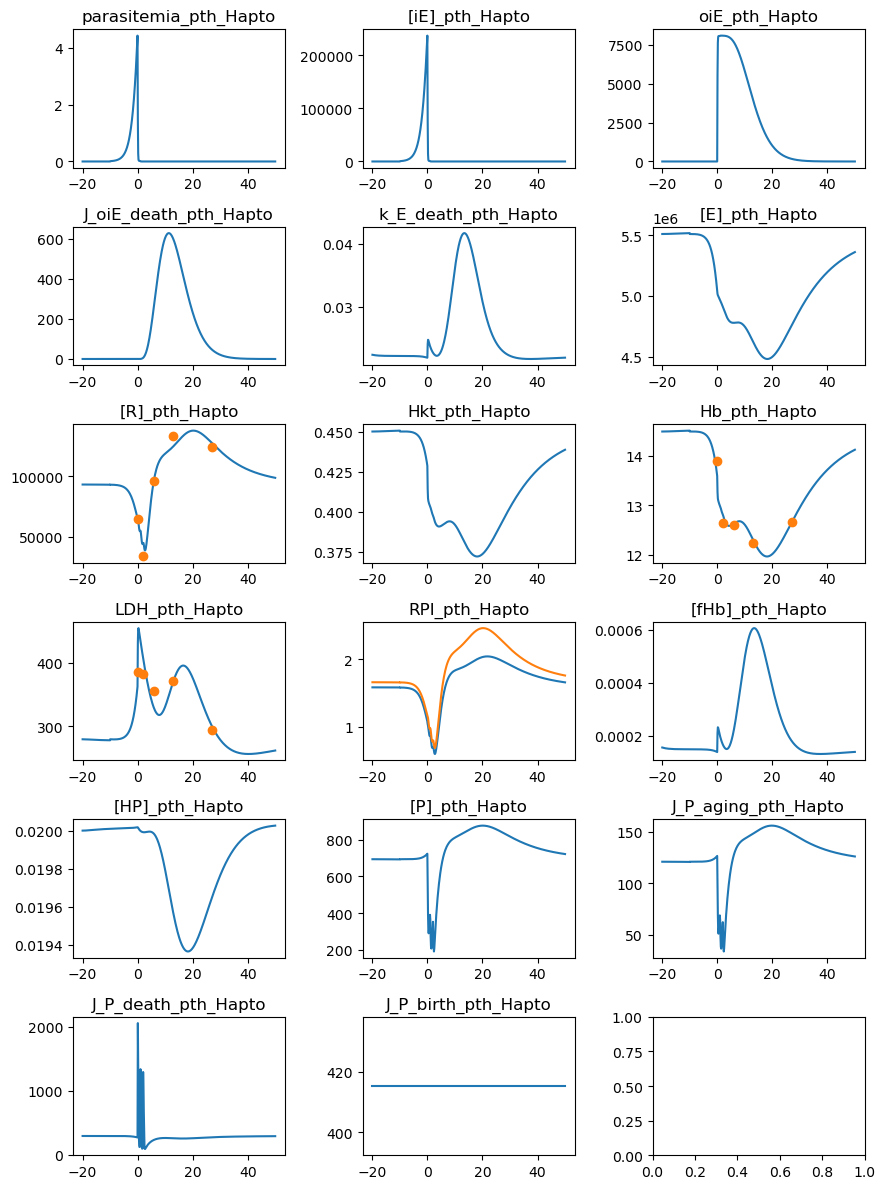

In [ ]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[fHb]','[HP]','[P]',
               'J_P_aging', 'J_P_death',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(h_pth_res_df['time'], h_pth_res_df[obs], label='no BH')
    ax[row, col].plot(h_pth_res_df['time'], h_pth_res_df[obs])

    ax[row, col].set_title(obs+f"_pth_{name}")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='data')
# maturation time = 1, assumption Hkt does go underneath 0.4, in model   
rpi_calc = (h_pth_res_df['[R]'] / (h_pth_res_df['[R]'] + h_pth_res_df['[E]']+h_pth_res_df['[iE]'] + h_pth_res_df['oiE'])) * h_pth_res_df['Hkt'] / (0.45*0.01)
ax[3, 1].plot(h_pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()

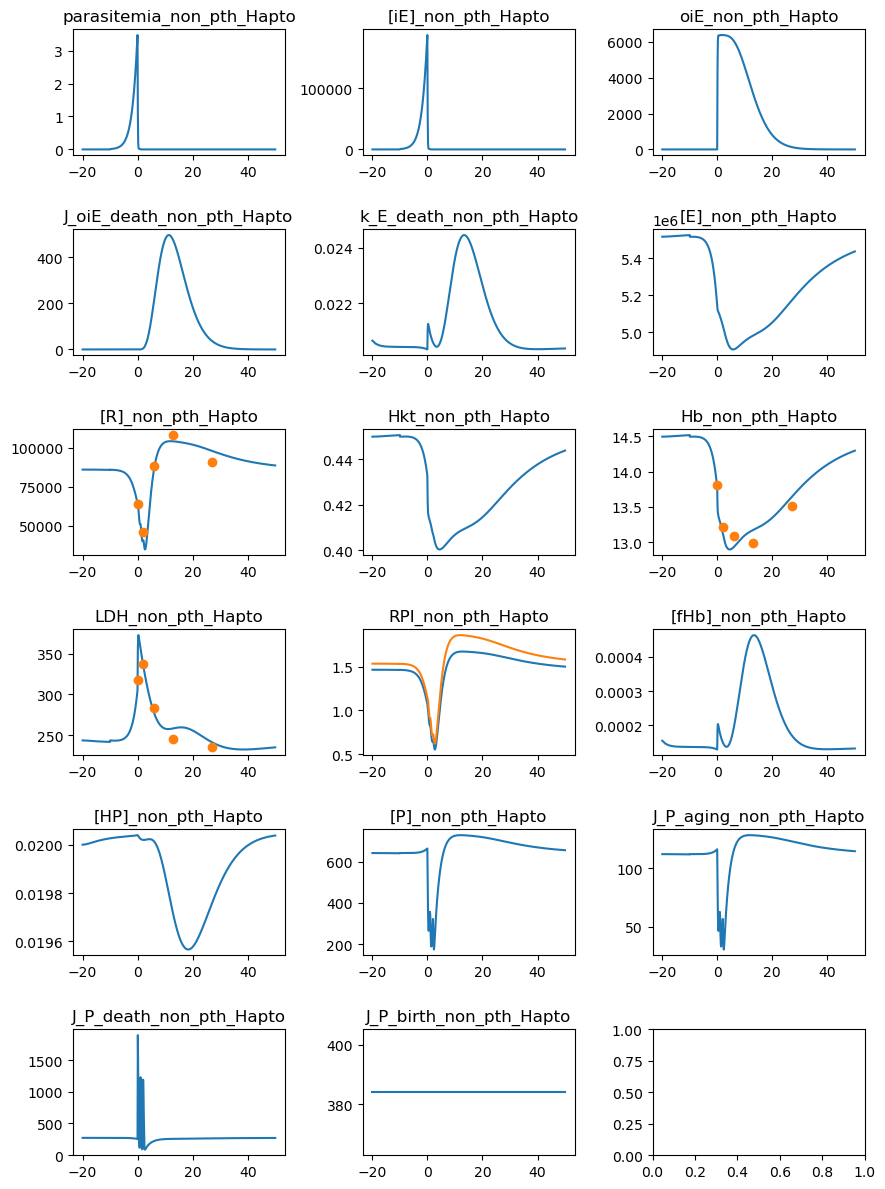

In [ ]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[fHb]','[HP]','[P]',
               'J_P_aging', 'J_P_death',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(h_non_pth_res_df['time'], h_non_pth_res_df[obs], label='no BH')
    ax[row, col].plot(h_non_pth_res_df['time'], h_non_pth_res_df[obs])

    ax[row, col].set_title(obs+f"_non_pth_{name}")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['[R]_mean'], 'o', label='data')
# maturation time = 1, assumption Hkt does go underneath 0.4, in model   
rpi_calc = (h_non_pth_res_df['[R]'] / (h_non_pth_res_df['[R]'] + h_non_pth_res_df['[E]']+h_non_pth_res_df['[iE]'] + h_non_pth_res_df['oiE'])) * h_non_pth_res_df['Hkt'] / (0.45*0.01)
ax[3, 1].plot(h_non_pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()

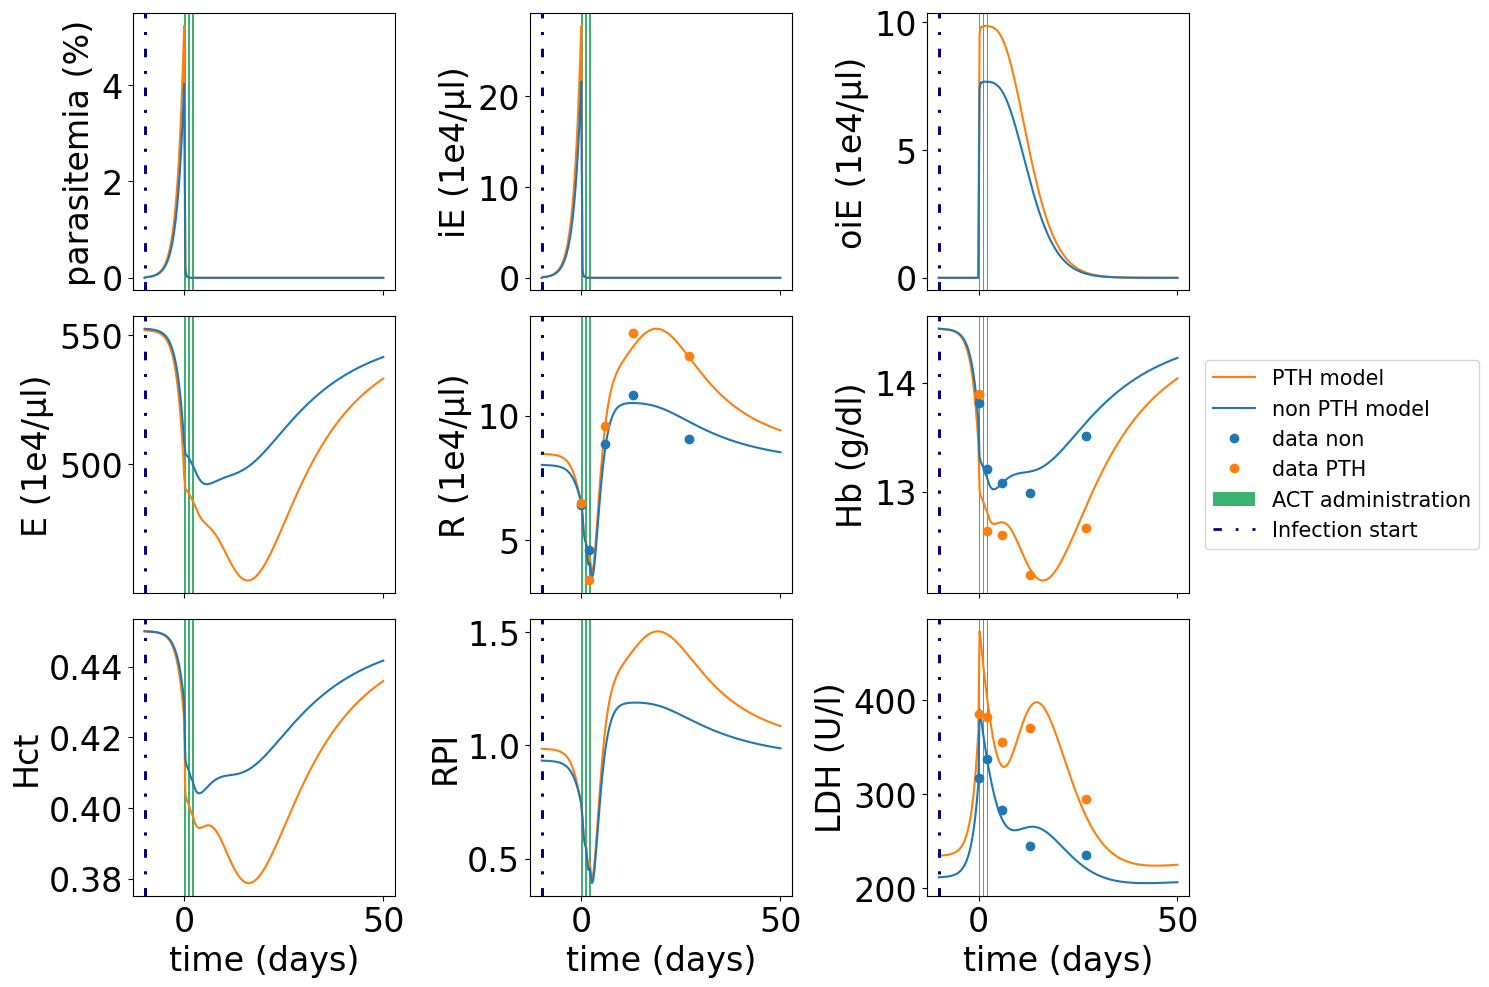

In [ ]:
cols = 3
rows = 3  
fig, axs_all = plt.subplots(rows,cols, figsize=(15,10), sharex=True)
fig.subplots_adjust(hspace=0.38, wspace= 0.42)
size_of_font = 24
color = ['tab:orange','tab:blue']
for i,data in enumerate([g_pth_res_df,g_non_pth_res_df]):
    pretty_plot(data, axs_all, color[i])
axs_all[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data', color='tab:blue')
axs_all[1,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data',color='tab:blue')
axs_all[1,1].plot(fit_data_non_pth['Time'], fit_data_non_pth['[R]_mean']/1e4, 'o', label='data', color='tab:blue')

axs_all[2,2].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='PTH data',color='tab:orange')
axs_all[1,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='PTH data',color='tab:orange')
axs_all[1,1].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean']/1e4, 'o', label='PTH data',color='tab:orange')

handles, labels = axs_all[1, -1].get_legend_handles_labels()  # Legend Box outsides Subplots

axs_all[1,-1].legend(handles[0:1]+handles[3:4]+handles[6:]+handles[1:3], ['PTH model','non PTH model','data non','data PTH','ACT administration','Infection start'], loc='center left', 
                  bbox_to_anchor=(1.02, 0.5), fontsize=15
                  ) 
plt.tight_layout()  

fig.savefig('general_model.svg', dpi=300)


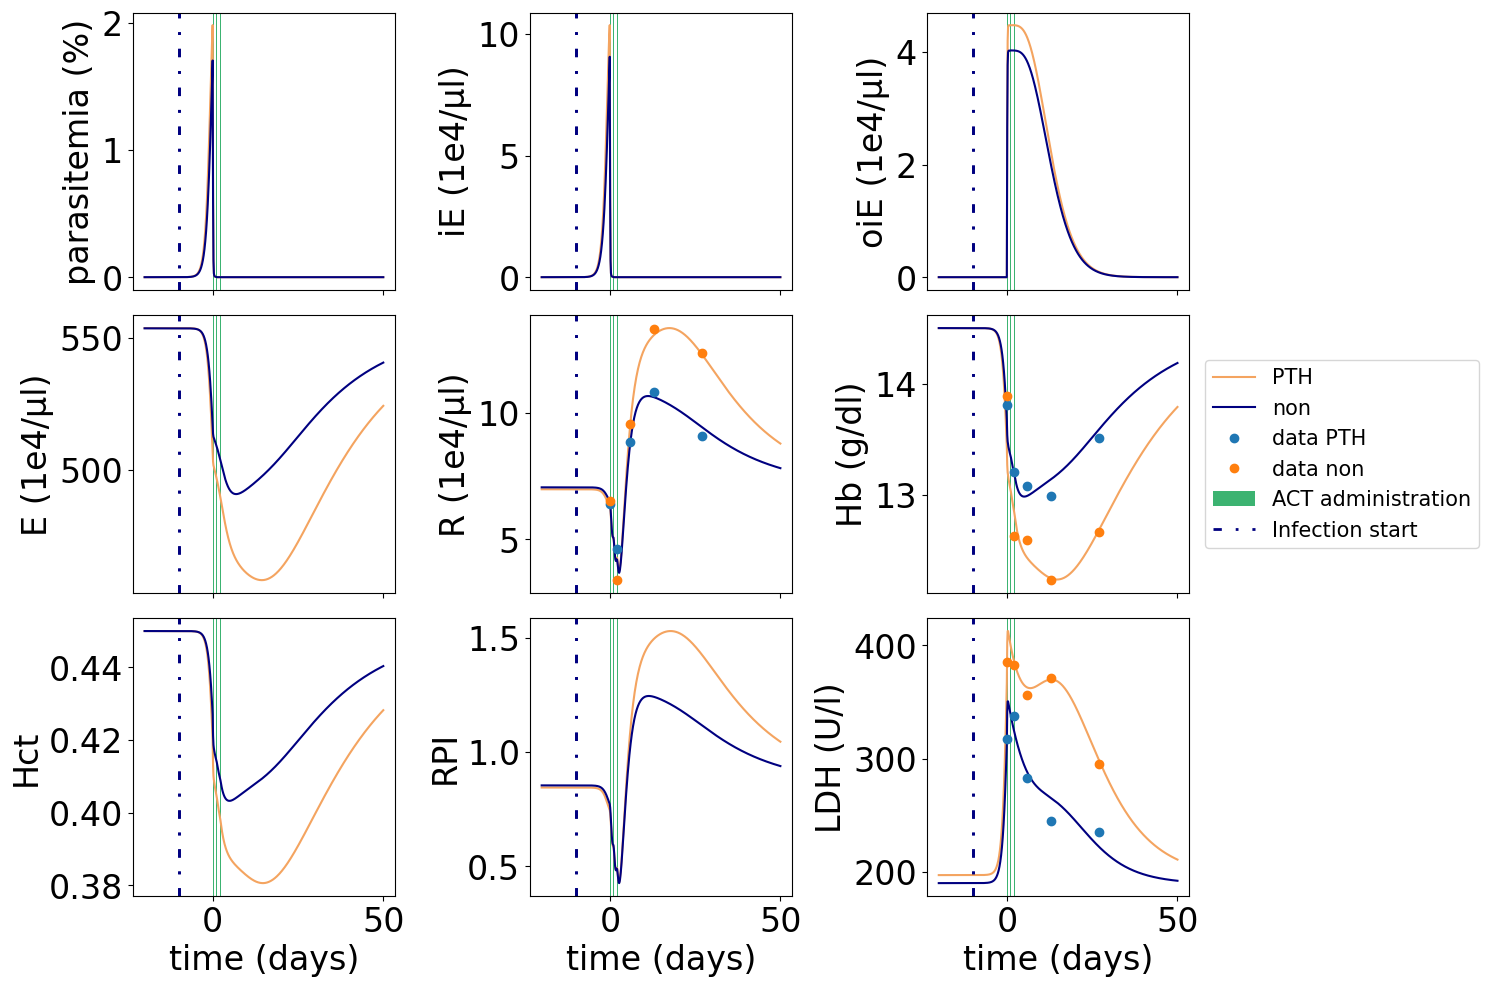

In [ ]:
cols = 3
rows = 3  
fig, axs_all = plt.subplots(rows,cols, figsize=(15,10), sharex=True)
fig.subplots_adjust(hspace=0.38, wspace= 0.42)
size_of_font = 24
color = ['sandybrown', 'navy','darkorange','dodgerblue' ]
for i,data in enumerate([i_pth_res_df, i_non_pth_res_df,]):
    pretty_plot(data, axs_all, color[i])
axs_all[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data', color='tab:blue')
axs_all[1,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data',color='tab:blue')
axs_all[1,1].plot(fit_data_non_pth['Time'], fit_data_non_pth['[R]_mean']/1e4, 'o', label='data', color='tab:blue')

axs_all[2,2].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='PTH data',color='tab:orange')
axs_all[1,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='PTH data',color='tab:orange')
axs_all[1,1].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean']/1e4, 'o', label='PTH data',color='tab:orange')

handles, labels = axs_all[1, -1].get_legend_handles_labels()  # Legend Box outsides Subplots

axs_all[1,-1].legend(handles[0:1]+handles[3:4]+handles[6:]+handles[1:3], ['PTH','non','data PTH','data non','ACT administration','Infection start'], loc='center left', 
                  bbox_to_anchor=(1.02, 0.5), fontsize=15
                  ) 
plt.tight_layout()  

fig.savefig('immune_model.svg', dpi=300)

In [ ]:
cols = 3
rows = 3  
fig, axs_all = plt.subplots(rows,cols, figsize=(15,8), sharex=True)
fig.subplots_adjust(hspace=0.38, wspace= 0.42)
size_of_font = 24
color = ['darkorange','dodgerblue' ]
for i,data in enumerate([h_pth_res_df, h_non_pth_res_df,]):
    pretty_plot(data, axs_all, color[i])
axs_all[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data', color='tab:blue')
axs_all[1,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data',color='tab:blue')
axs_all[1,1].plot(fit_data_non_pth['Time'], fit_data_non_pth['[R]_mean']/1e4, 'o', label='data', color='tab:blue')

axs_all[2,2].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='PTH data',color='tab:orange')
axs_all[1,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='PTH data',color='tab:orange')
axs_all[1,1].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean']/1e4, 'o', label='PTH data',color='tab:orange')

handles, labels = axs_all[1, -1].get_legend_handles_labels()  # Legend Box outsides Subplots

axs_all[1,-1].legend(handles[0:1]+handles[3:4]+handles[6:]+handles[1:3], ['Hapto PTH','Hapto non','data PTH','data non','ACT administration','Infection start'], loc='center left', 
                  bbox_to_anchor=(1.02, 0.5), fontsize=15
                  ) 
plt.tight_layout()  

fig.savefig('hapto_model.svg', dpi=300)

<Figure size 1500x800 with 9 Axes>

In [ ]:
for k, v in akaike_score_dict.items():
    print(f'{k} score: {v}')

general_pth score: (125.89185356819783, 63, ['t_mat_P', 't_R_a_init', 'scale_rpi', 'slope_rpi', 'Hkt_init', 'step_1', 'step_2', 'step_3', 't_P_a_init', 'k_P_birth', 'LDH_RBC', 'Vol_blood', 't_E_death', 'Vol_E', 'Vol_R', 'a_P_d', 'k_P_d', 'r_P_d', 'k_P_art_max', 'h_art', 'ID50', 'fac_R_d', 's_BH', 'tropism', 'k_E_infect', 'k_iE_death_0', 'k_iE_pit_frac', 'k_iE_art_max', 'k_iE_rupture', 't_iE_rupture', 'k_M_death', 'k_ART_decay', 't_halb_ART_decay', 'k_iE_pit_0', 'k_LDH_decay', 't_halb_LDH_decay', 'N_A', 'Vol_iE', 'Vol_oiE', 'Hb_conc_R', 'Hb_conc_E', 'Hb_conc_iE', 'Hb_conc_oiE', 'events_medication_on', 't_ART_add', 'k_R_death', 'oiE', 'k_oiE_death', 'k_P_death', 'Hb', 'k_P_aging', 't_P_aging', 'rpi_step_func', 'k_R_aging', 'Hkt', 'k_E_death', 'k_iE_death', 'k_iE_pit', 'Vol_plasma', 'parasitemia', 'R_percent', 'RPI', 'oiE_percent'])
general_non score: (125.89185356819783, 63, ['t_mat_P', 't_R_a_init', 'scale_rpi', 'slope_rpi', 'Hkt_init', 'step_1', 'step_2', 'step_3', 't_P_a_init', 'k_P_b